# 1 Modeling Volatiliy

Find data for historical prices for any publicly traded equity. To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pybroker
import yfinance as yf
from pybroker.data import DataSource
from pybroker.ext.data import AKShare
import warnings
from pylab import mpl
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['savefig.dpi'] = 300 # 分辨率为300
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [3]:
STRAT_DATE = '2021-01-01'
END_DATE = '2024-09-30'
MSFT = yf.Ticker('MSFT') 
hist = MSFT.history(start=STRAT_DATE, end=END_DATE)

## Constant Volatility
If the stock price follows **Geometric Brownian Motion**, then 
$$
\begin{aligned}
d\ln(S)=\left( \mu-\frac{1}{2}\sigma^{2} \right)dt+\sigma dB
\end{aligned}
$$
hence 
$$
\begin{gathered}
\Delta \ln S =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma\Delta B \\
\ln S(t_i)-\ln S(t_{i-1}) =\quad\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma(B(t_i)-B(t_{i-1})) \\
\frac{\ln S(t_i)-\ln S(t_{i-1})}{\sqrt{\Delta t}} =\quad\left(\mu-\frac12\sigma^2\right)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}} 
\end{gathered}
$$

here we let $\Delta t=1$ day, let $y_{i}=\frac{\ln S(t_{i})-\ln S(t_{i-1})}{\sqrt{ \Delta t }}$, then 
$$
\begin{aligned}
\hat{\sigma}^{2}& =\frac{1}{N-1}\left(\sum_{i=1}^{N}y_{i}^{2}-N\bar{y}^{2}\right) \\
\end{aligned}
$$
and 
$$
\hat{\mu}=\bar{y}+\frac{1}{2}\hat{\sigma}^{2}
$$

In [4]:
# read local data
df = pd.read_csv('MSFT_stock_data.csv', index_col=0)
df.set_index('date', inplace=True)

# calculate log returns
df['y'] = np.log(df['close'] / df['close'].shift(1))
df.dropna(inplace=True)

# estimate parameters
y_bar = df['y'].mean()
N = len(df)
sigma_hat = np.std(df['y'])
mu_hat = y_bar + 1 / 2 * sigma_hat ** 2

print(f"mu_hat = {mu_hat:.4f}", f"sigma_hat = {sigma_hat:.4f}")

mu_hat = 0.0009 sigma_hat = 0.0166


## GARCH Model

We use GARCH(1, 1) model to fit $y_{i}$, to get our conditional variance

In [5]:
import arch
garch_model = arch.arch_model(df['y'], vol='garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
df['GARCH_volatility'] =(garch_fit.conditional_volatility)
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2561.99
Distribution:                  Normal   AIC:                          -5115.97
Method:            Maximum Likelihood   BIC:                          -5096.60
                                        No. Observations:                  939
Date:                Mon, Oct 14 2024   Df Residuals:                      938
Time:                        14:49:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0715e-03  6.916e-06    154.917      0.000 [1.058e-03,1.085e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.5168e-06  5.780e-11  9.545e+04      0.000 [5.517e-06,5.517e-06]
alpha[1]       0.0500  1.154e-02      4.332  1.479e-05 [2.737e-02,7.261e-02]
beta[1]        0.9298  1.068e-02     87.049      0.000     [  0.909,  0.951]
============================================================================

Covariance estimator: robust
"""

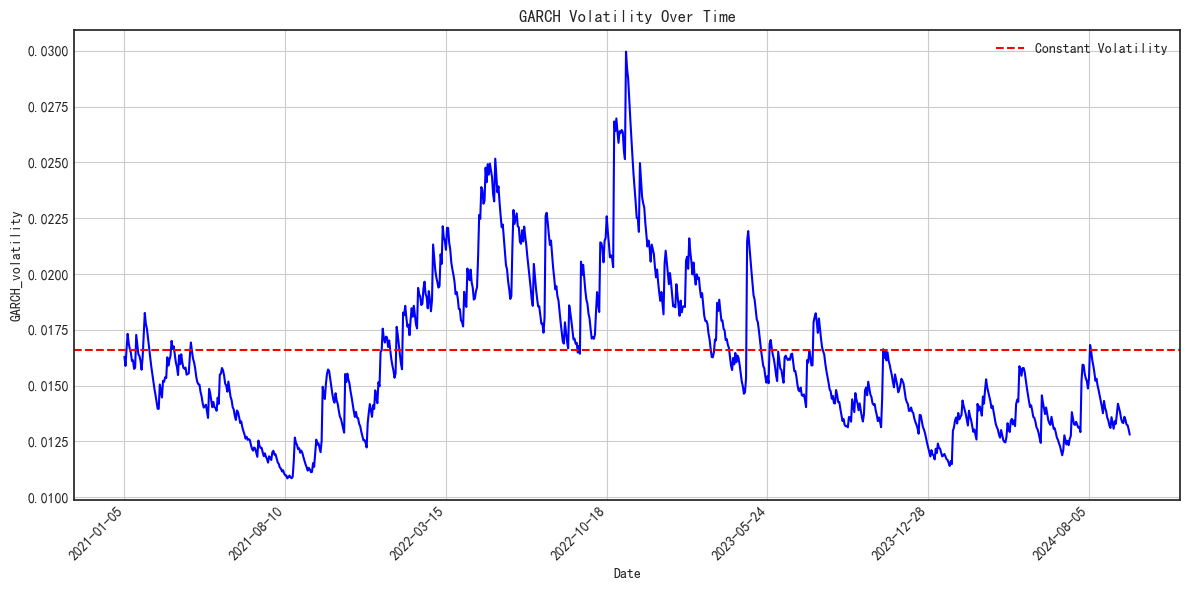

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['GARCH_volatility'], linestyle='-', color='b')
plt.axhline(y=sigma_hat, color='r', linestyle='--', label='Constant Volatility')
plt.xlabel('Date')
plt.ylabel('GARCH_volatility')
plt.title('GARCH Volatility Over Time')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()